# COMMON SETUP

In [1]:

import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

DATA_PATH = "/content/mental Health Dataset  - mental_health_dataset_with_real_life_added (1).csv"

df = pd.read_csv(DATA_PATH)

# Quick sanity checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(2))

# Standardize likely column names (adjust if needed)
# Expected: Text, Language, has_emoji, label_1
# If your dataset has slightly different names, edit here:
TEXT_COL = "Text"
LANG_COL = "Language"
EMOJI_COL = "has_emoji"
LABEL_COL = "label_1"

# Drop rows missing essential fields
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()

# Optional: normalize has_emoji to 0/1 if it isn't already
if EMOJI_COL in df.columns:
    df[EMOJI_COL] = df[EMOJI_COL].astype(str).str.strip().replace({"True": "1", "False": "0"})
    df[EMOJI_COL] = pd.to_numeric(df[EMOJI_COL], errors="coerce").fillna(0).clip(0, 1).astype(int)
else:
    df[EMOJI_COL] = 0  # if column doesn't exist, create it

# If Language column missing, create an "unknown"
if LANG_COL not in df.columns:
    df[LANG_COL] = "unknown"

# Target labels
df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()

# Train/test split
X = df[[TEXT_COL, LANG_COL, EMOJI_COL]].copy()
y = df[LABEL_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Label distribution:\n", y.value_counts())


Shape: (5565, 6)
Columns: ['Text', 'Language', 'has_emoji', 'label_1', 'label_number-1', '\n\n']
                                                Text Language  has_emoji  \
0  ঘুম ভালো হচ্ছে আর মনোযোগও ঠিক আছে; মোটের উপর ভ...   Bangla       True   
1  সাম্প্রতিক কাজের চাপ বেড়ে যায়; একটু বিশ্রামও প...   Bangla       True   

  label_1  label_number-1  \n\n  
0  Normal             4.0   NaN  
1  Stress             2.0   NaN  
Train: (4452, 3) Test: (1113, 3)
Label distribution:
 label_1
Stress        1782
Depression    1775
Anxiety       1760
Suicidal       221
Normal          27
Name: count, dtype: int64


# 1 CODE: PREPROCESSING + FEATURE ENGINEERING

In [2]:

def basic_clean_text(s: str) -> str:
    """
    Lightweight cleaning suitable for mixed Bangla/English/Banglish.
    - lowercases
    - removes URLs, emails
    - keeps letters/numbers/emoji-ish symbols as much as possible
    - normalizes whitespace
    """
    if pd.isna(s):
        return ""
    s = str(s)

    # Remove URLs/emails
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"\S+@\S+", " ", s)

    # Lowercase (safe for English/Banglish; Bangla unaffected)
    s = s.lower()

    # Replace multiple spaces/newlines with single space
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Apply cleaning to train/test
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
X_train_clean[TEXT_COL] = X_train_clean[TEXT_COL].apply(basic_clean_text)
X_test_clean[TEXT_COL] = X_test_clean[TEXT_COL].apply(basic_clean_text)

# Build feature transformers:
# - TF-IDF on text
# - One-hot on language
# - passthrough on has_emoji

text_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_features=5000
)

preprocess = ColumnTransformer(
    transformers=[
        ("text", text_vectorizer, TEXT_COL),
        ("lang", OneHotEncoder(handle_unknown="ignore"), [LANG_COL]),
        ("emoji", "passthrough", [EMOJI_COL]),
    ],
    remainder="drop"
)

print("preprocessing pipeline ready.")


Member 1: preprocessing pipeline ready.


# 2 CODE: TRAIN + COMPARE CLASSIFIERS

In [3]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    "NaiveBayes": MultinomialNB(),
    "DecisionTree": DecisionTreeClassifier(
        random_state=42,
        max_depth=None
    ),
    "RandomForest": RandomForestClassifier(
        random_state=42,
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        class_weight="balanced"
    )
}

# Train + evaluate each model
results = []

for name, clf in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("clf", clf)
    ])

    pipe.fit(X_train_clean, y_train)
    preds = pipe.predict(X_test_clean)

    print("\n======================")
    print("MODEL:", name)
    print("======================")
    print(classification_report(y_test, preds))

    cm = confusion_matrix(y_test, preds, labels=sorted(y.unique()))
    print("Confusion Matrix (labels sorted):\n", cm)

    results.append((name, pipe))

# Select best model by macro F1 via cross-val on train (optional but recommended)
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_name, best_pipe, best_score = None, None, -1

for name, _ in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("clf", models[name])])
    oof_pred = cross_val_predict(pipe, X_train_clean, y_train, cv=skf, n_jobs=-1)
    score = f1_score(y_train, oof_pred, average="macro")
    print(f"CV Macro-F1 {name}: {score:.4f}")

    if score > best_score:
        best_score = score
        best_name = name
        best_pipe = pipe

print("\nBest by CV Macro-F1:", best_name, "Score:", best_score)

# Fit best model on full training data
best_pipe.fit(X_train_clean, y_train)
best_test_pred = best_pipe.predict(X_test_clean)

print("\n=== Best Model Test Report ===")
print("Best Model:", best_name)
print(classification_report(y_test, best_test_pred))



MODEL: NaiveBayes
              precision    recall  f1-score   support

     Anxiety       0.98      0.86      0.92       352
  Depression       0.96      0.92      0.94       355
      Normal       1.00      0.50      0.67         6
      Stress       0.91      0.90      0.90       356
    Suicidal       0.24      0.61      0.34        44

    accuracy                           0.88      1113
   macro avg       0.82      0.76      0.75      1113
weighted avg       0.92      0.88      0.90      1113

Confusion Matrix (labels sorted):
 [[303   7   0   6  36]
 [  1 325   0  11  18]
 [  1   0   3   0   2]
 [  1   6   0 319  30]
 [  2   2   0  13  27]]

MODEL: DecisionTree
              precision    recall  f1-score   support

     Anxiety       0.89      0.89      0.89       352
  Depression       0.87      0.91      0.89       355
      Normal       0.71      0.83      0.77         6
      Stress       0.96      0.87      0.91       356
    Suicidal       0.27      0.36      0.31      

# 3 CODE: PATTERN DISCOVERY + INTERPRETATION

In [4]:

from sklearn.linear_model import LogisticRegression

probe = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced"))
])

probe.fit(X_train_clean, y_train)

# Extract feature names from ColumnTransformer
# Note: this requires sklearn >= 1.0-ish. If it errors, tell me your sklearn version.
tfidf = probe.named_steps["preprocess"].named_transformers_["text"]
lang_ohe = probe.named_steps["preprocess"].named_transformers_["lang"]

tfidf_features = tfidf.get_feature_names_out()
lang_features = lang_ohe.get_feature_names_out([LANG_COL])
all_feature_names = np.concatenate([tfidf_features, lang_features, np.array([EMOJI_COL])])

coef = probe.named_steps["clf"].coef_
classes = probe.named_steps["clf"].classes_

def top_features_for_class(class_index, top_k=20):
    weights = coef[class_index]
    top_pos_idx = np.argsort(weights)[-top_k:][::-1]
    top_neg_idx = np.argsort(weights)[:top_k]
    return (
        list(zip(all_feature_names[top_pos_idx], weights[top_pos_idx])),
        list(zip(all_feature_names[top_neg_idx], weights[top_neg_idx]))
    )

print("\n=== TOP FEATURES PER CLASS (LogReg probe) ===")
for i, c in enumerate(classes):
    pos, neg = top_features_for_class(i, top_k=15)
    print(f"\nClass: {c}")
    print("  Most indicative (+):")
    for feat, w in pos:
        print(f"    {feat}: {w:.4f}")
    print("  Least indicative (-):")
    for feat, w in neg:
        print(f"    {feat}: {w:.4f}")

# 2) Decision tree rules (interpretable) - train a shallow tree for readable rules
from sklearn.tree import DecisionTreeClassifier, export_text

tree_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", DecisionTreeClassifier(
        random_state=42,
        max_depth=4,           # shallow for readability
        min_samples_leaf=10
    ))
])

tree_model.fit(X_train_clean, y_train)

# Get the transformed feature space dimension and names
# export_text needs the classifier + feature_names
tree_clf = tree_model.named_steps["clf"]

# Build feature names again
all_feature_names = np.concatenate([tfidf.get_feature_names_out(), lang_features, np.array([EMOJI_COL])])

tree_rules = export_text(tree_clf, feature_names=list(all_feature_names), max_depth=4)
print("\n=== SHALLOW DECISION TREE RULES ===")
print(tree_rules)

# 3) Error analysis: show some misclassified examples from best model
# Use best_pipe from Member 2 (make sure you ran Member 2 cell first)
preds = best_pipe.predict(X_test_clean)
errors = X_test_clean.copy()
errors["true"] = y_test.values
errors["pred"] = preds
errors["is_error"] = (errors["true"] != errors["pred"])

print("\nTotal errors:", errors["is_error"].sum(), "out of", len(errors))

# Show a few errors per true class
for c in sorted(y.unique()):
    sample = errors[(errors["true"] == c) & (errors["is_error"])].head(5)
    if len(sample) == 0:
        continue
    print(f"\n--- Misclassified examples (true={c}) ---")
    for _, row in sample.iterrows():
        print("Text:", row[TEXT_COL])
        print("Lang:", row[LANG_COL], "Emoji:", row[EMOJI_COL], "Pred:", row["pred"])
        print("---")



=== TOP FEATURES PER CLASS (LogReg probe) ===

Class: Anxiety
  Most indicative (+):
    পর: 2.9397
    chinta: 1.9136
    কর: 1.5194
    nervous: 1.4706
    social: 1.4169
    মন হয়: 1.3969
    হয় সবক: 1.3969
    সবক ড়ত: 1.3969
    again: 1.3836
    রব: 1.2599
    কর রণ: 1.2599
    রব কর: 1.2599
    make: 1.2362
    make me: 1.2362
    খত: 1.2136
  Least indicative (-):
    আর: -1.4301
    the: -0.9589
    stressed: -0.9426
    stressed with: -0.9426
    হচ: -0.9421
    feel: -0.9345
    কম: -0.9152
    আর পড়: -0.8151
    পড়: -0.8151
    পর আর: -0.8151
    একট: -0.7903
    in: -0.7815
    কষ: -0.7791
    করত: -0.7727
    উপর: -0.7484

Class: Depression
  Most indicative (+):
    কম: 2.3333
    তর কম: 1.9190
    feel: 1.8125
    করত: 1.7305
    faka: 1.5550
    তর: 1.3649
    low: 1.2279
    seems enjoyable: 1.2279
    nothing seems: 1.2279
    been feeling: 1.2279
    been: 1.2279
    ve: 1.2279
    ve been: 1.2279
    nothing: 1.2279
    enjoyable: 1.2279
  Least indicative (-):
   

#Plot 1: Class Distribution

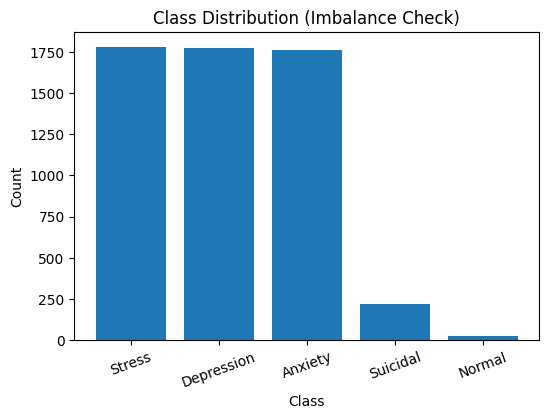

Class %:
 label_1
Stress        32.02
Depression    31.90
Anxiety       31.63
Suicidal       3.97
Normal         0.49
Name: count, dtype: float64


In [5]:
import matplotlib.pyplot as plt

counts = df[LABEL_COL].value_counts()

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(counts.index.astype(str), counts.values)
ax.set_title("Class Distribution (Imbalance Check)")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.xticks(rotation=20)
plt.show()

print("Class %:\n", (counts / counts.sum() * 100).round(2))


#Plot 2: Model Comparison (Macro-F1 Bar Chart)

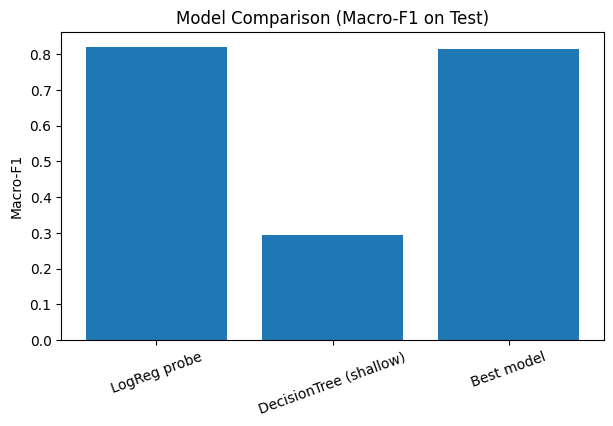

Macro-F1 scores: {'LogReg probe': 0.8210432030521148, 'DecisionTree (shallow)': 0.29276313668967113, 'Best model': 0.8135037611278463}
✅ Using existing best_pipe from your notebook.


In [9]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# ---- If you already have a dict like: pipes = {"NB": pipe1, "RF": pipe2, ...} ----
# If not, fallback to at least compare probe vs tree_model vs best_pipe (if they exist)
model_dict = {}

if "pipes" in globals() and isinstance(pipes, dict) and len(pipes) > 0:
    model_dict = pipes
else:
    # fallback using whatever exists in your notebook variables
    if "probe" in globals(): model_dict["LogReg probe"] = probe
    if "tree_model" in globals(): model_dict["DecisionTree (shallow)"] = tree_model
    if "best_pipe" in globals(): model_dict["Best model"] = best_pipe

# pick correct test X variable
X_for_test = X_test_clean if "X_test_clean" in globals() else X_test

scores = {}
for name, model in model_dict.items():
    pred = model.predict(X_for_test)
    scores[name] = f1_score(y_test, pred, average="macro")

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(list(scores.keys()), list(scores.values()))
ax.set_title("Model Comparison (Macro-F1 on Test)")
ax.set_ylabel("Macro-F1")
plt.xticks(rotation=20)
plt.show()

print("Macro-F1 scores:", scores)

# define best_pipe automatically if not already defined
if "best_pipe" not in globals():
    best_name = max(scores, key=scores.get)
    best_pipe = model_dict[best_name]
    print("✅ Auto-selected best_pipe:", best_name)
else:
    print("✅ Using existing best_pipe from your notebook.")


#Plot 3: Normalized Confusion Matrix

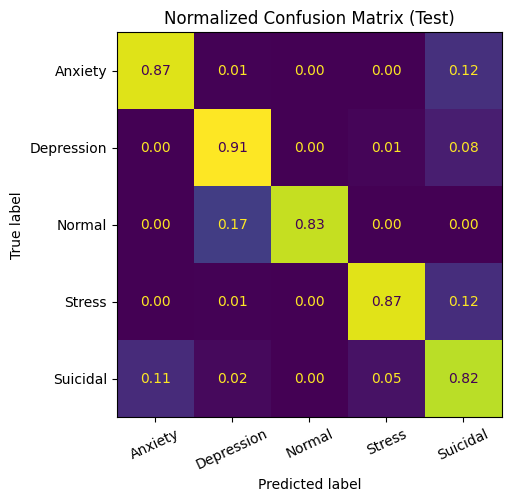

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_for_test = X_test_clean if "X_test_clean" in globals() else X_test
y_pred = best_pipe.predict(X_for_test)

labels_sorted = sorted(y_test.unique())
cm_norm = confusion_matrix(y_test, y_pred, labels=labels_sorted, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels_sorted)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, xticks_rotation=25, values_format=".2f", colorbar=False)
ax.set_title("Normalized Confusion Matrix (Test)")
plt.show()


#Plot 4: Learning Curve (Overfitting Check)

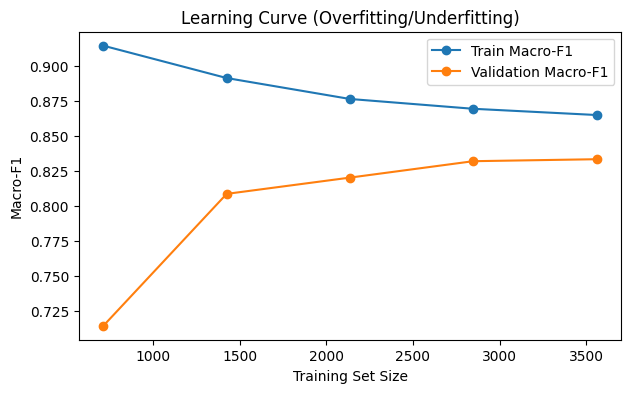

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

X_for_train = X_train_clean if "X_train_clean" in globals() else X_train

train_sizes, train_scores, val_scores = learning_curve(
    best_pipe,
    X_for_train,
    y_train,
    cv=5,
    scoring="f1_macro",
    train_sizes=[0.2, 0.4, 0.6, 0.8, 1.0],
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(train_sizes, train_mean, marker="o", label="Train Macro-F1")
ax.plot(train_sizes, val_mean, marker="o", label="Validation Macro-F1")
ax.set_title("Learning Curve (Overfitting/Underfitting)")
ax.set_xlabel("Training Set Size")
ax.set_ylabel("Macro-F1")
ax.legend()
plt.show()
